# Analysis

In [1]:
zipcode = 75008

In [2]:
import pandas as pd
import datetime
import numpy as np
import itertools
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from sklearn.linear_model import LinearRegression
import warnings

warnings.filterwarnings("ignore")
df = pd.read_csv(f"{zipcode}.csv")

In [3]:
df.drop(["start_year", "start_month", "start_day_number", "start_hour", "start_minutes"], axis = 1, inplace = True)
df = df[df['day_number']!=0]
df = df[df['end_day_number']!=0]
df.columns


Index(['Unnamed: 0', 'car_plate_number', 'status', 'group_id',
       'kibana_duration', 'distance', 'zipcode', 'delta_battery', 'latitude',
       'longitude', 'end_year', 'end_month', 'end_day_number', 'end_hour',
       'end_minutes', 'time_since_2020', 'duration', 'next_group_id', 'year',
       'month', 'day_number', 'hour', 'minute', 'day_of_week'],
      dtype='object')

In [4]:
def geo_block(dataframe, district):
    return dataframe[dataframe['zipcode']==district]

def time_block(dataframe, start_time, end_time, scripted_day):
    return dataframe.loc[(dataframe['hour']>= start_time) & (dataframe['hour']<= end_time) & (dataframe['day_of_week']==scripted_day)]

def time_block_extended(dataframe, start_time, end_time, scripted_day1, scripted_day2):
    return dataframe.loc[(dataframe['hour']>= start_time) & (dataframe['hour']<= end_time) & (dataframe['day_of_week']>=scripted_day1) & (dataframe['day_of_week']<=scripted_day2)]
    

In [5]:
time_blocks = [(0, 5), (6, 9), (10, 11), (12, 13), (14, 15), (16, 18), (19, 23)] # obtained from the daily num
geo_blocks = df['zipcode'].unique()
days = np.sort(df['day_of_week'].unique())
days_dict = {1: "Monday", 2:"Tuesday", 3:"Wednesday", 4:"Thursday", 5:"Friday", 6: "Saturday", 7: "Sunday"}
monthdict = {"Jan": 0, "Feb": 1, "Mar": 2, "Apr": 3, "May": 4, "Jun": 5, "Jul": 6, "Aug": 7, "Sep": 8, "Oct": 9, "Nov": 10,  "Dec": 11}
inv_month = {v: k for k, v in monthdict.items()}

In [6]:
print(days)

[0 1 2 3 4 5 6]


In [6]:
df['month'] = df['month'].map(monthdict)+1
df['month'] = df['month'].astype(int)
df['day_number'] = df['day_number'].astype(int)
df['year'] = df['year'].astype(int)

In [7]:
df = df.fillna(0)
float_col = df.select_dtypes(include=['float64']) # This will select float columns only
for col in float_col.columns.values:
    df[col] = df[col].astype('int64')

## Split overlapping segments to match time blocks

In [8]:
def split(index, block_list):
    additional_segments = pd.DataFrame()
    if df.loc[index, 'status']=="FREE":
        start_minute, end_minute = df.loc[index, "minute"], df.loc[index, "end_minutes"]
        start_hour, end_hour = df.loc[index, "hour"], df.loc[index, "end_hour"]
        start_day, end_day = df.loc[index, "day_number"], df.loc[index, "end_day_number"]
        month, end_month = df.loc[index, "month"], df.loc[index, "end_month"]
        year, end_year = df.loc[index, "year"], df.loc[index, "end_year"]
        start_block = 0 # To which block belongs the start hour ?
        while start_block < len(block_list) and start_hour >= block_list[start_block][0] :
            start_block+=1
        start_block-=1
        end_block = len(block_list)-1 # To which block belongs the end hour ?
        while end_block >= 0 and end_hour <= block_list[end_block][1] :
            end_block-=1
        end_block+=1
        if start_day==end_day:
            if start_block!=end_block:
                new_segment = df.loc[index]
                new_segment['end_hour']=block_list[start_block][1]
                additional_segments = additional_segments.append(new_segment, ignore_index = True)
                for block in range(start_block+1, end_block):
                    new_segment = df.loc[index]
                    new_segment['hour']=block_list[block][0]
                    new_segment['end_hour']=block_list[block][1]
                    new_segment['duration']=int((datetime.datetime(end_year, end_month, end_day, end_hour, end_minute) - datetime.datetime(end_year, end_month, end_day, block_list[block][0], 0)).seconds/60)
                    additional_segments = additional_segments.append(new_segment, ignore_index = True)
                new_segment = df.loc[index]
                new_segment['hour']=block_list[end_block][0]
                additional_segments = additional_segments.append(new_segment, ignore_index = True)
                df.drop(index, inplace=True)
        else :
            # Create segments start day
            new_segment = df.loc[index]
            new_segment['end_hour']=block_list[start_block][1]
            new_segment['end_day_number']=start_day
            new_segment['end_month']=month
            new_segment['duration']=int((datetime.datetime(end_year, end_month, end_day, end_hour, end_minute) - datetime.datetime(year, month, start_day, block_list[start_block][0], 0)).seconds/60)
            additional_segments = additional_segments.append(new_segment, ignore_index = True)
            for block in range(start_block+1, len(block_list)):
                new_segment = df.loc[index]
                new_segment['hour']=block_list[block][0]
                new_segment['end_hour']=block_list[block][1]
                new_segment['end_day_number']=start_day
                new_segment['end_month']=month
                new_segment['duration']=int((datetime.datetime(end_year, end_month, end_day, end_hour, end_minute) - datetime.datetime(year, month, start_day, block_list[block][0], 0)).seconds/60)
                additional_segments = additional_segments.append(new_segment, ignore_index = True)
            # Create segments end day
            for block in range(0, end_block):
                new_segment = df.loc[index]
                new_segment['hour']=block_list[block][0]
                new_segment['end_hour']=block_list[block][1]
                new_segment['day_number']=end_day
                new_segment['month']=end_month
                new_segment['duration']=int((datetime.datetime(end_year, end_month, end_day, end_hour, end_minute) - datetime.datetime(end_year, end_month, end_day, block_list[block][0], 0)).seconds/60)
                additional_segments = additional_segments.append(new_segment, ignore_index = True)
            new_segment = df.loc[index]
            new_segment['hour']=block_list[end_block][0]
            new_segment['day_number']=end_day
            new_segment['month']=end_month
            new_segment['duration']=int((datetime.datetime(end_year, end_month, end_day, end_hour, end_minute) - datetime.datetime(end_year, end_month, end_day, block_list[end_block][0], 0)).seconds/60)
            additional_segments = additional_segments.append(new_segment, ignore_index = True)
            # Create segments other days
            try :
                date = datetime.date(year, month, start_day)
                date += datetime.timedelta(days=1)
                end_date = datetime.date(end_year, end_month, end_day)
            except Exception as e:
                print(e)
                print(year, month, start_day)
                return additional_segments
                
            while date < end_date:
                for block in range(0, len(block_list)):
                    new_segment = df.loc[index]
                    new_segment['hour']=block_list[block][0]
                    new_segment['end_hour']=block_list[block][1]
                    new_segment['day_number']=date.day
                    new_segment['end_day_number']=date.day
                    new_segment['month']=date.month
                    new_segment['duration']=int((datetime.datetime(end_year, end_month, end_day, end_hour, end_minute) - datetime.datetime(end_year, date.month, date.day, block_list[block][0], 0)).seconds/60)
                    additional_segments = additional_segments.append(new_segment, ignore_index = True)
                date += datetime.timedelta(days=1)
            df.drop(index, inplace=True)
    return additional_segments

In [9]:
split_df = pd.DataFrame()
for index in df.index:
    split_df = split_df.append(split(index, time_blocks), ignore_index = True)
split_df.info()

KeyboardInterrupt: 

In [ ]:
df = df.append(split_df, ignore_index = True)
def get_week_day(index):
    day = int(df.loc[index, 'day_number'])
    month = int(df.loc[index, 'month'])
    year = int(df.loc[index, 'year'])
    if day==0:
        # Bug: 179 entries with date 2021-01-0, scripted_day_of_week was indicating 3 in isoweekday
        return 2
    return datetime.date(year, month, day).weekday()

df['day_of_week']=df.index.map(get_week_day)
df.to_csv(f"{zipcode}_split.csv")

In [10]:
df = pd.read_csv("75008_split.csv")

In [11]:
def get_week_day(index):
    day = int(df.loc[index, 'day_number'])
    month = int(df.loc[index, 'month'])
    year = int(df.loc[index, 'year'])
    if day==0:
        return 2
    return datetime.date(year, month, day).weekday()

df['day_of_week']=df.index.map(get_week_day)

## Average availability duration

No handles with labels found to put in legend.


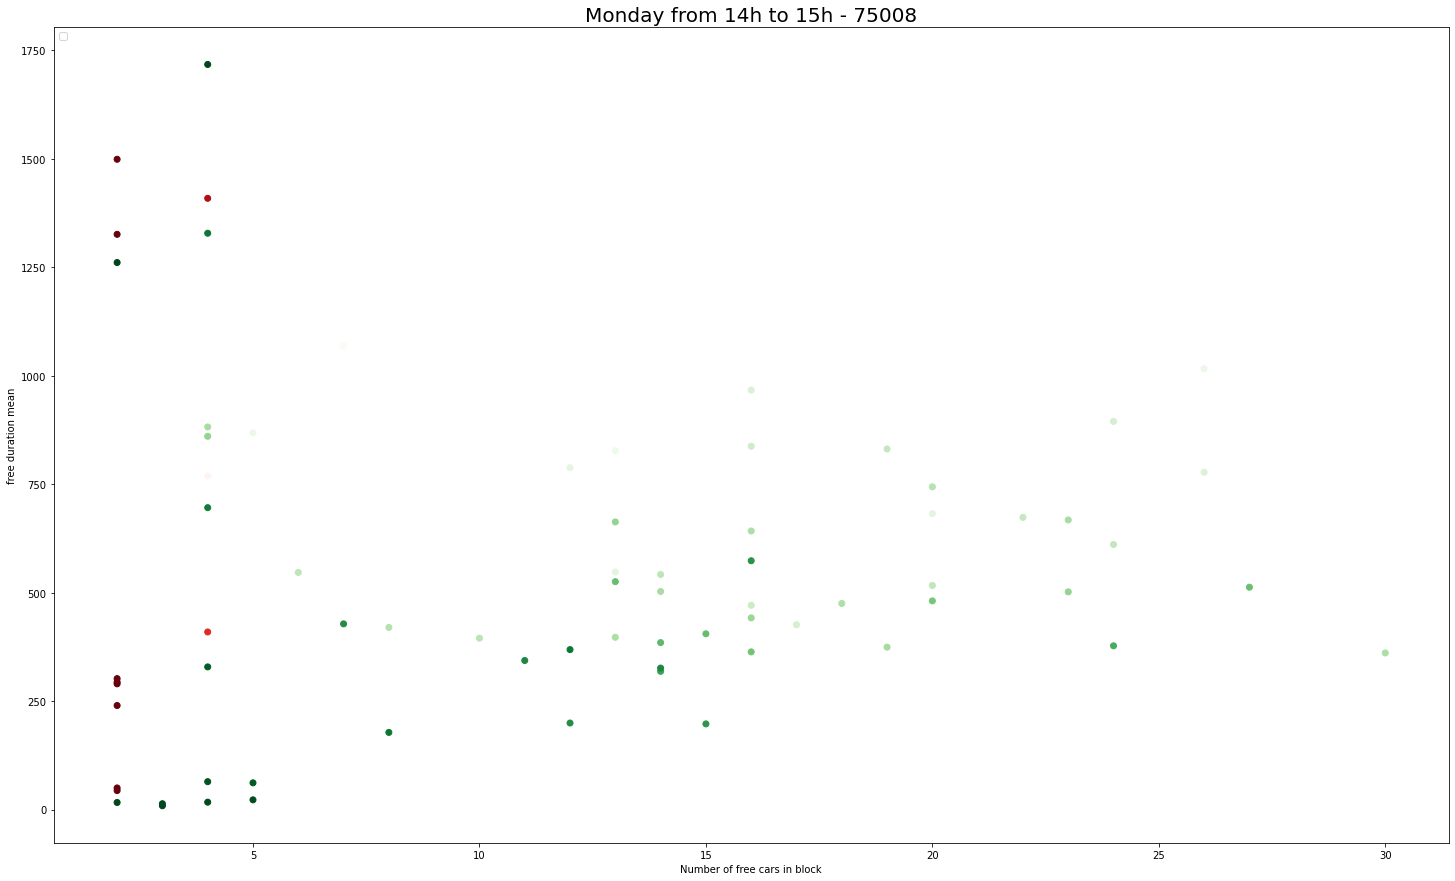

In [12]:
district = zipcode
start_date, end_date = time_blocks[4]
day=0
end_day =0

# Next group is any
dataframe = geo_block(df, district)
dataframe = time_block_extended(dataframe, start_date, end_date, day, end_day).loc[dataframe["status"]=="FREE"]
dataframe = dataframe[dataframe['kibana_duration']<2000] # filter segments with duration > 2000 minutes = 33 hours
grouped_df = dataframe.groupby(by=['month', 'day_number', 'year']).agg({'year': 'first', 'month': 'first', 'day_number': 'first', 'kibana_duration': ['mean', 'count', 'std'], 'next_group_id': 'first'})
durations_means = np.array(grouped_df['kibana_duration']['mean'].values)
standards = np.array(grouped_df['kibana_duration']['std'].values)
count = np.array(grouped_df['kibana_duration']['count'].values)
dates = (grouped_df['year'].astype(str) + "/" + grouped_df['month'].astype(str) + "/" + grouped_df['day_number'].astype(str)).values

# Next group-id is Client
dataframe = geo_block(df, district)
dataframe = time_block_extended(dataframe, start_date, end_date, day, end_day).loc[dataframe["status"]=="FREE"]
dataframe = dataframe[dataframe['next_group_id']=='Client']
dataframe = dataframe[dataframe['kibana_duration']<2000] # filter segments with duration > 2000 minutes = 33 hours
grouped_df = dataframe.groupby(by=['month', 'day_number', 'year']).agg({'year': 'first', 'month': 'first', 'day_number': 'first', 'kibana_duration': ['mean', 'count', 'std'], 'next_group_id': 'first'})
client_durations_means = np.array(grouped_df['kibana_duration']['mean'].values)
client_standards = np.array(grouped_df['kibana_duration']['std'].values)
client_count = np.array(grouped_df['kibana_duration']['count'].values)
client_dates = (grouped_df['year'].astype(str) + "/" + grouped_df['month'].astype(str) + "/" + grouped_df['day_number'].astype(str)).values

# Next group-id is driver
dataframe = geo_block(df, district)
dataframe = time_block_extended(dataframe, start_date, end_date, day, end_day).loc[dataframe["status"]=="FREE"]
dataframe = dataframe[dataframe['next_group_id']!='Client']
dataframe = dataframe[dataframe['kibana_duration']<2000] # filter segments with duration > 2000 minutes = 33 hours
grouped_df = dataframe.groupby(by=['month', 'day_number', 'year']).agg({'year': 'first', 'month': 'first', 'day_number': 'first', 'kibana_duration': ['mean', 'count', 'std'], 'next_group_id': 'first'})
driver_durations_means = np.array(grouped_df['kibana_duration']['mean'].values)
driver_standards = np.array(grouped_df['kibana_duration']['std'].values)
driver_count = np.array(grouped_df['kibana_duration']['count'].values)
driver_dates = (grouped_df['year'].astype(str) + "/" + grouped_df['month'].astype(str) + "/" + grouped_df['day_number'].astype(str)).values



x = np.array(count).reshape(-1, 1)
y = np.array(durations_means)
a, _, _, _ = np.linalg.lstsq(x, y-1)

reg = LinearRegression().fit(x, y)
steep = reg.coef_[0]
intercept = reg.intercept_
pearson, p_value = pearsonr(count, durations_means)

plt.figure(figsize=(25, 15))

plt.scatter(client_count,  client_durations_means, c=client_standards, cmap='Greens_r') # Points with lower standard deviation are shaded darker.
plt.scatter(driver_count,  driver_durations_means, c=driver_standards, cmap='Reds_r') # Points with lower standard deviation are shaded darker.

# plt.plot(count, a*count+1, c='red', label = "Slope: %a" %(int(a[0]*1000)/1000) + f"\nPearson : {(int(pearson*1000)/1000)}" )
# plt.plot(count, steep*count+intercept, c='blue')

"""
for i, v in enumerate(client_count):
    plt.text(client_count[i], 1.01*client_durations_means[i]+3, "%s" %client_dates[i][0], ha="left")
for i, v in enumerate(driver_count):
    plt.text(driver_count[i], 1.01*driver_durations_means[i]+3, "%s" %driver_dates[i][0], ha="left")
    """

plt.xlabel("Number of free cars in block")
plt.ylabel("free duration mean")
plt.legend(loc="upper left")
plt.title(f"{days_dict[day+1]} from {start_date}h to {end_date}h - {zipcode}", fontsize=20)
plt.show()

## Free duration (no average)

In [13]:
# Next group is any
dataframe = geo_block(df, district)
dataframe = time_block_extended(dataframe, start_date, end_date, day, end_day).loc[dataframe["status"]=="FREE"]
dataframe = dataframe[dataframe['kibana_duration']<2000] # filter segments with duration > 2000 minutes = 33 hours
grouped_df = dataframe.groupby(by=['month', 'day_number', 'year']).agg({'year': 'first', 'month': 'first', 'day_number': 'first', 'kibana_duration': ['mean', 'count', 'std']})
count = np.array(grouped_df['kibana_duration']['count'].values)
dates = np.squeeze((grouped_df['year'].astype(str) + grouped_df['month'].astype(str) + grouped_df['day_number'].astype(str)).values)

count_dict = dict(list(zip(dates, count)))

def calculate_count(index):
    date = str(df.loc[index, 'year'])+ str(df.loc[index, 'month']) + str(df.loc[index, 'day_number'])
    return(count_dict[date])

dataframe['count']=dataframe.index.map(calculate_count)

No handles with labels found to put in legend.


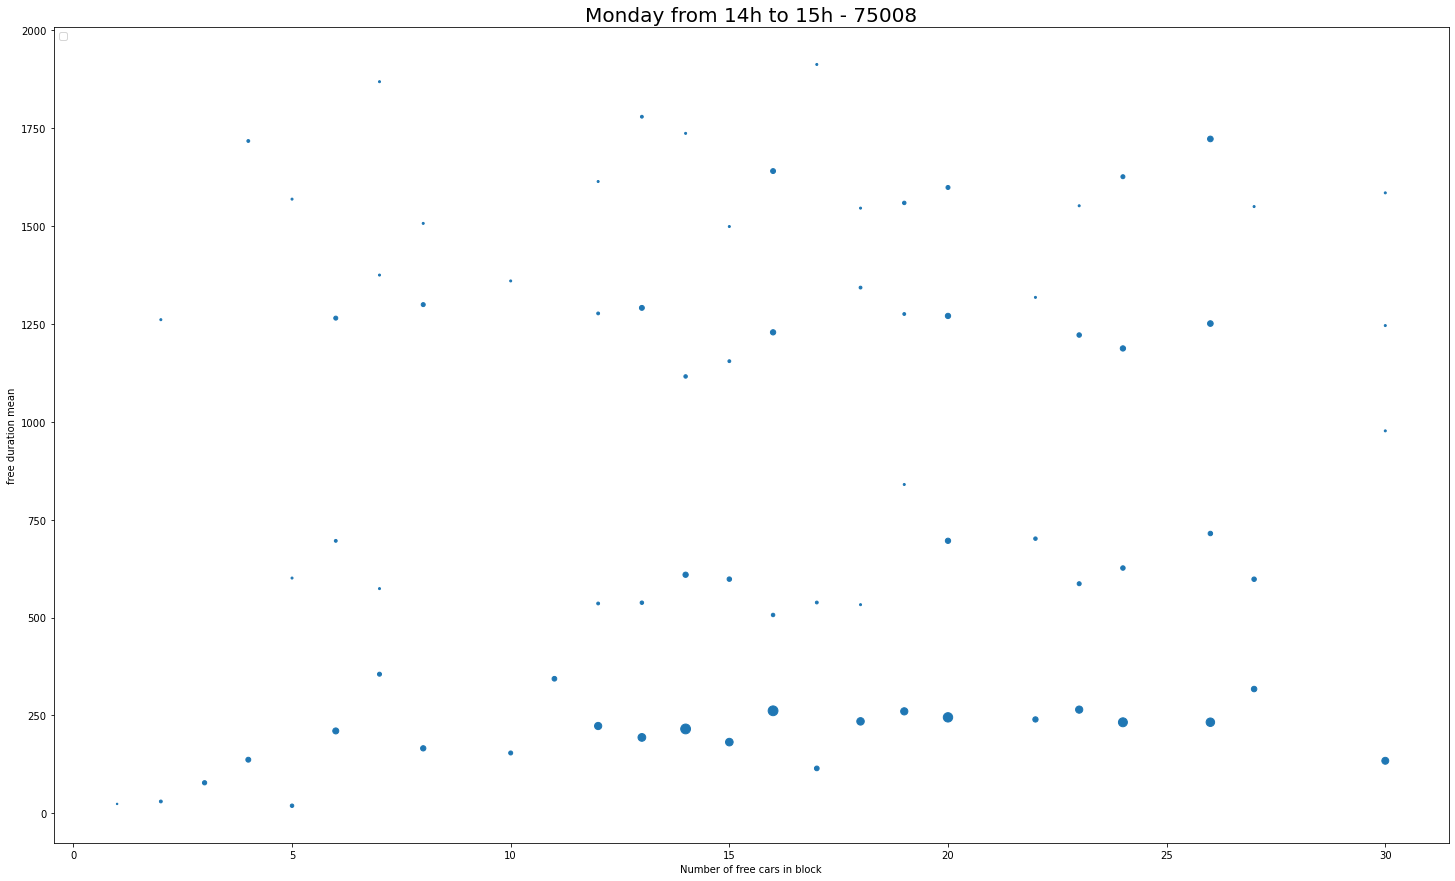

In [14]:
count = np.array(dataframe['count'].values)
durations = np.array(dataframe['kibana_duration'].values)

grouped_df = dataframe.groupby(by=['count', pd.cut(dataframe['kibana_duration'], 4)]).agg({'count': 'first', 'kibana_duration': ['mean', 'count']})

plt.figure(figsize=(25, 15))

# plt.scatter(count,  durations) # Points with lower standard deviation are shaded darker.
plt.scatter(grouped_df['count']['first'], grouped_df['kibana_duration']['mean'], s=grouped_df['kibana_duration']['count']*2)

# plt.plot(count, a*count+1, c='red', label = "Slope: %a" %(int(a[0]*1000)/1000) + f"\nPearson : {(int(pearson*1000)/1000)}" )
# plt.plot(count, steep*count+intercept, c='blue')

"""
for i, v in enumerate(client_count):
    plt.text(client_count[i], 1.01*client_durations_means[i]+3, "%s" %client_dates[i][0], ha="left")
for i, v in enumerate(driver_count):
    plt.text(driver_count[i], 1.01*driver_durations_means[i]+3, "%s" %driver_dates[i][0], ha="left")
    """

plt.xlabel("Number of free cars in block")
plt.ylabel("free duration mean")
plt.legend(loc="upper left")
plt.title(f"{days_dict[day+1]} from {start_date}h to {end_date}h - {zipcode}", fontsize=20)
plt.show()

## Booking number & estimated 

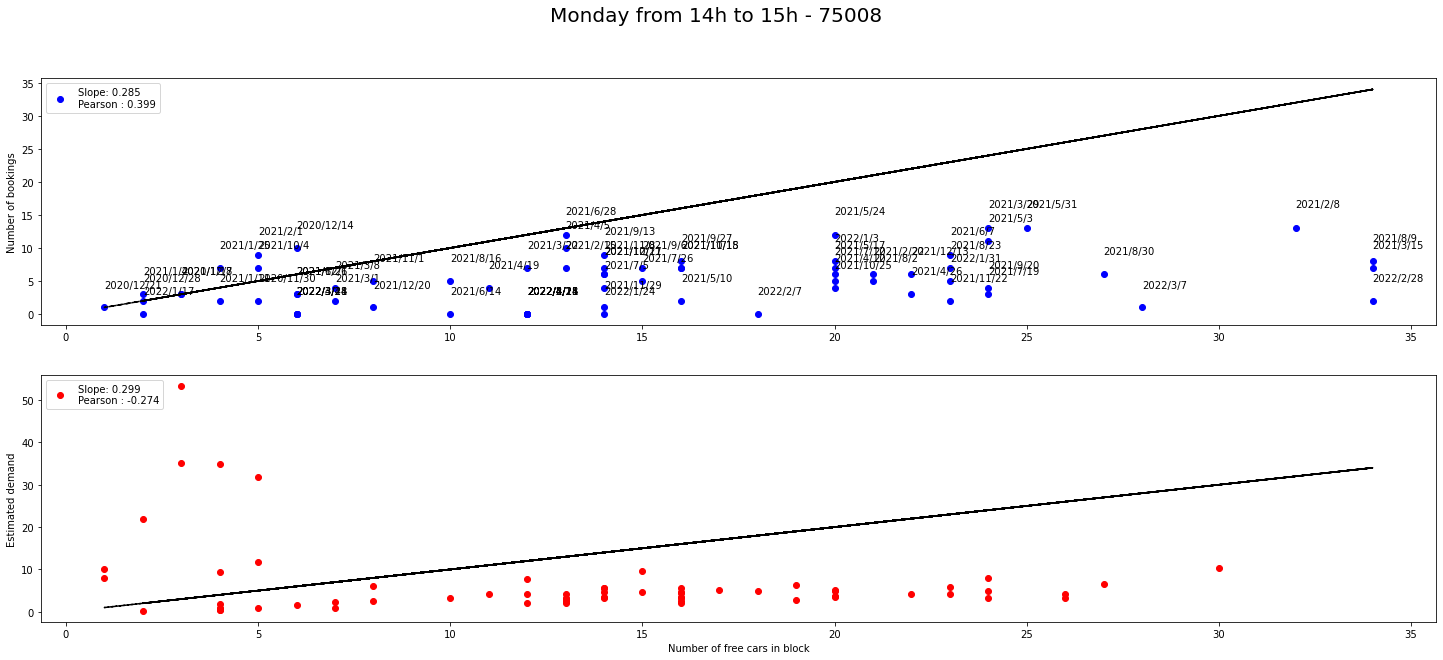

In [17]:
dataframe = geo_block(df, district)
dataframe = time_block_extended(dataframe, start_date, end_date, day, end_day)
df1 = dataframe.groupby(by=['month', 'day_number', 'year'])['status'].apply(lambda x: (x!='FREE').sum()).reset_index(name='booked_count')
df2 = dataframe.groupby(by=['month', 'day_number', 'year'])['status'].apply(lambda x: (x=='FREE').sum()).reset_index(name='free_count')
booked_count = np.array(df1['booked_count'].values)
free_count = df2['free_count'].values
dates = (df2['year'].astype(int).astype(str) + "/" + df2['month'].astype(int).astype(str) + "/" + df2['day_number'].astype(int).astype(str)).values

mu = ((1+client_count)/client_durations_means)*(end_date-start_date+1)*60 # queuing theory

x = np.array(free_count).reshape(-1, 1)
y = np.array(booked_count)
a, _, _, _ = np.linalg.lstsq(x, y)
pearson = pearsonr(free_count, booked_count)[0]

x = np.array(client_count).reshape(-1, 1)
y = np.array(mu)
a_mu, _, _, _ = np.linalg.lstsq(x, y)
pearson_mu = pearsonr(client_count, mu)[0]

fig, (ax1, ax2) = plt.subplots(2)

# fig.rcParams["figure.autolayout"] = True
# plt.plot(free_count, a*free_count, c='red', label = "Slope: %a" %(int(a[0]*1000)/1000) + f"\nPearson : {(int(pearson*1000)/1000)}" )
fig.set_figheight(10)
fig.set_figwidth(25)
ax1.plot(free_count, booked_count, 'bo', label = "Slope: %a" %(int(a[0]*1000)/1000) + f"\nPearson : {(int(pearson*1000)/1000)}")
ax1.plot(free_count, free_count, 'k--')
#ax1.plot(free_count, raw_demand, 'bo', c='red')
#ax1.plot(free_count, [np.mean(booked_count)]*len(free_count))
#ax1.plot(free_count, [np.mean(raw_demand+)]*len(free_count), c='red')
ax2.plot(client_count, mu, 'bo', c='red', label = "Slope: %a" %(int(a_mu[0]*1000)/1000) + f"\nPearson : {(int(pearson_mu*1000)/1000)}")
ax2.plot(free_count, free_count, 'k--')

for i, v in enumerate(free_count):
    ax1.text(free_count[i], 1.01*booked_count[i]+3, "%s" %dates[i], ha="left")

#ax1.set_ylim([0,50])
#ax2.set_ylim([0, 50])
#ax1.set_xlim([0,60])
#ax2.set_xlim([0, 60])
ax2.set_xlabel("Number of free cars in block")
ax1.set_ylabel("Number of bookings")
ax2.set_ylabel("Estimated demand")
ax1.legend(loc="upper left")
ax2.legend(loc="upper left")
fig.suptitle(f"{days_dict[day+1]} from {start_date}h to {end_date}h - {zipcode}", fontsize=20)
plt.show()

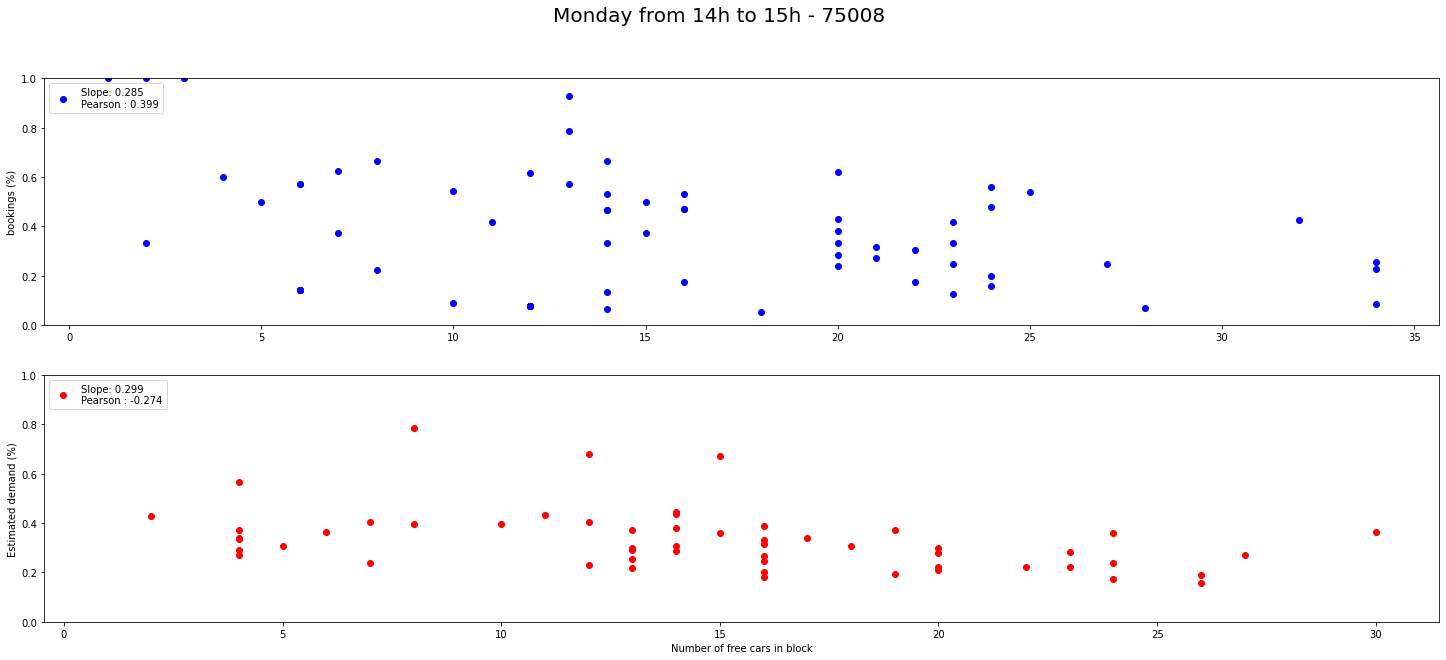

In [18]:
dataframe = geo_block(df, district)
dataframe = time_block_extended(dataframe, start_date, end_date, day, end_day)
df1 = dataframe.groupby(by=['month', 'day_number', 'year'])['status'].apply(lambda x: (x!='FREE').sum()).reset_index(name='booked_count')
df2 = dataframe.groupby(by=['month', 'day_number', 'year'])['status'].apply(lambda x: (x=='FREE').sum()).reset_index(name='free_count')
booked_count = np.array(df1['booked_count'].values)
free_count = df2['free_count'].values
mu = np.array(((1+client_count)/client_durations_means)*(end_date-start_date+1)*60) # queuing theory

x = np.array(free_count).reshape(-1, 1)
y = np.array(booked_count)
a, _, _, _ = np.linalg.lstsq(x, y)
pearson = pearsonr(free_count, booked_count)[0]

x = np.array(client_count).reshape(-1, 1)
y = np.array(mu)
a_mu, _, _, _ = np.linalg.lstsq(x, y)
pearson_mu = pearsonr(client_count, mu)[0]

fig, (ax1, ax2) = plt.subplots(2)

# fig.rcParams["figure.autolayout"] = True
# plt.plot(free_count, a*free_count, c='red', label = "Slope: %a" %(int(a[0]*1000)/1000) + f"\nPearson : {(int(pearson*1000)/1000)}" )
fig.set_figheight(10)
fig.set_figwidth(25)
ax1.plot(free_count, (1+booked_count)/(1+free_count), 'bo', label = "Slope: %a" %(int(a[0]*1000)/1000) + f"\nPearson : {(int(pearson*1000)/1000)}")
#ax1.plot(free_count, free_count, 'k--')
#ax1.plot(free_count, raw_demand, 'bo', c='red')
#ax1.plot(free_count, [np.mean(booked_count)]*len(free_count))
#ax1.plot(free_count, [np.mean(raw_demand+)]*len(free_count), c='red')
ax2.plot(client_count, (1+mu)/(1+client_count), 'bo', c='red', label = "Slope: %a" %(int(a_mu[0]*1000)/1000) + f"\nPearson : {(int(pearson_mu*1000)/1000)}")
#ax2.plot(free_count, free_count, 'k--')
ax1.set_ylim([0, 1])
ax2.set_ylim([0, 1])
#ax1.set_xlim([0,60])
#ax2.set_xlim([0, 60])
ax2.set_xlabel("Number of free cars in block")
ax1.set_ylabel("bookings (%)")
ax2.set_ylabel("Estimated demand (%)")
ax1.legend(loc="upper left")
ax2.legend(loc="upper left")
fig.suptitle(f"{days_dict[day+1]} from {start_date}h to {end_date}h - {zipcode}", fontsize=20)
plt.show()

## Corrélations

In [149]:
cor, days, starts, stops, lengths = [], [], [], [], []
for day in range(0, 7):
    for start_date, end_date in time_blocks:
        dataframe = geo_block(df, district)
        dataframe = time_block(dataframe, start_date, end_date, day).loc[dataframe["status"]=="FREE"]
        dataframe = dataframe[dataframe['kibana_duration']<2000] # filter segments with duration > 2000 minutes = 33 hours
        grouped_df = dataframe.groupby(by=['month', 'day_number', 'year']).agg({'year': 'first', 'month': 'first', 'day_number': 'first', 'kibana_duration': ['mean', 'count', 'std']})
        durations_means = grouped_df['kibana_duration']['mean'].values
        count = grouped_df['kibana_duration']['count'].values
        try :
            cor.append(pearsonr(count, durations_means)[0])
            days.append(days_dict[day+1])
            starts.append(start_date)
            stops.append(end_date)
            lengths.append(len(count))
        except Exception as e:
            print(e)
cor_df = pd.DataFrame(list(zip(days, starts, stops, cor, lengths)), columns=['day', 'start hour',  'end hour', 'Pearson correlation coefficient', 'Number of blocks'])
cor_df
         

,day,start hour,end hour,Pearson correlation coefficient,Number of blocks
0,Monday,0,5,0.207654,120
1,Monday,6,9,0.024396,120
2,Monday,10,11,-0.350642,118
3,Monday,12,13,-0.520803,117
4,Monday,14,15,-0.633969,114
5,Monday,16,18,-0.624835,111
6,Monday,19,23,-0.505255,91
7,Tuesday,0,5,0.099549,122
8,Tuesday,6,9,-0.020178,127
9,Tuesday,10,11,-0.282293,118


## Tables

In [181]:
def estimated_demand_mean(df, district, start_date, end_date, day):
    dataframe = geo_block(df, district)
    dataframe = time_block(dataframe, start_date, end_date, day)
    grouped_df = dataframe.groupby(by=['month', 'day_number', 'year']).agg({'year': 'first', 'month': 'first', 'day_number': 'first', 'kibana_duration': ['mean', 'count', 'std']})
    count = np.array(grouped_df['kibana_duration']['count'].values)
    durations_means = np.array(grouped_df['kibana_duration']['mean'].values)
    mu = ((1+count)/durations_means)*(end_date-start_date+1)*60 # queuing theory
    return int(np.mean(mu))


In [182]:
def estimated_demand_std(df, district, start_date, end_date, day):
    dataframe = geo_block(df, district)
    dataframe = time_block(dataframe, start_date, end_date, day)
    grouped_df = dataframe.groupby(by=['month', 'day_number', 'year']).agg({'year': 'first', 'month': 'first', 'day_number': 'first', 'kibana_duration': ['mean', 'count', 'std']})
    count = np.array(grouped_df['kibana_duration']['count'].values)
    durations_means = np.array(grouped_df['kibana_duration']['mean'].values)
    mu = ((1+count)/durations_means)*(end_date-start_date+1)*60 # queuing theory
    return int(np.std(mu))

In [183]:
def number_of_bookings_mean(df, district, start_date, end_date, day):
    dataframe = geo_block(df, district)
    dataframe = time_block(dataframe, start_date, end_date, day)
    df1 = dataframe.groupby(by=['month', 'day_number', 'year'])['status'].apply(lambda x: (x!='FREE').sum()).reset_index(name='booked_count')
    booked_count = np.array(df1['booked_count'].values)
    return int(np.mean(booked_count))

In [184]:
def number_of_bookings_std(df, district, start_date, end_date, day):
    dataframe = geo_block(df, district)
    dataframe = time_block(dataframe, start_date, end_date, day)
    df1 = dataframe.groupby(by=['month', 'day_number', 'year'])['status'].apply(lambda x: (x!='FREE').sum()).reset_index(name='booked_count')
    booked_count = np.array(df1['booked_count'].values)
    return int(np.std(booked_count))

In [185]:
features = [estimated_demand_mean, number_of_bookings_mean, estimated_demand_std, number_of_bookings_std]
feature_names = ['estimated demand mean', 'number of bookings mean', 'estimated_demand_std', 'number_of_bookings_std']

In [186]:
# Calculating features and storing results in a dedicated dataframe
array = np.empty(shape=(0, 4+len(features)))
for day, (start_date, end_date), district in itertools.product(days, time_blocks, geo_blocks):
    row = [district, days_dict[day+1], start_date, end_date]
    for feature in features :
        row.append(feature(df, district, start_date, end_date, day))
    array = np.vstack([array, row])

results = pd.DataFrame(array, columns = ['district', 'day', 'start hour', 'end hour']+feature_names)

In [187]:
results

,district,day,start hour,end hour,estimated demand mean,number of bookings mean,estimated_demand_std,number_of_bookings_std
0,75015.0,Monday,0,5,16,2,58,4
1,75015.0,Monday,6,9,20,5,46,9
2,75015.0,Monday,10,11,6,2,17,5
3,75015.0,Monday,12,13,5,3,16,6
4,75015.0,Monday,14,15,6,4,18,7
5,75015.0,Monday,16,18,18,7,59,12
6,75015.0,Monday,19,23,18,6,60,9
7,75015.0,Tuesday,0,5,10,1,31,2
8,75015.0,Tuesday,6,9,18,3,60,8
9,75015.0,Tuesday,10,11,7,2,56,4
